# INM707 Deep Learning: Optimization - Coursework #
##  Part 2a:Advanced - LunarLander using Deep Q Network with Experience Replay, Exploration and Fixed Target#
### Author - Abin Abraham ###
The task is to successfully land the lunar lander on the moon by training an training using Deep Q Network with Experience Replay, Exploration and Fixed Target. The environment is solved when the 100 episode average is greater than 200 points.

## Setting up code and experiment for gamma-discount rate ##

In [2]:
#Code adapted from https://theaisummer.com/Taking_Deep_Q_Networks_a_step_further/ and INM707 Tutorial 6
#Importing required libraries for environment, data analysis and plotting
import gym
import random
import numpy as np
np.random.seed(0)
from collections import deque
import matplotlib.pyplot as plt

#Loading keras tensorflow libraries
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import adam
from keras.activations import relu, linear


#Implmentation of DQN with exploration, experience, replay and fixed target
class DQN:
    def __init__(self,env, lr, gamma, epsilon, epsilon_decay, episodes):
        self.env = env
        self.action_space = env.action_space.n
        self.state_space = env.observation_space.shape[0]
        self.epsilon = epsilon # exploration rate: how much to act randomly; more initially than later due to epsilon decay
        self.gamma = gamma # discount rate: enables agent to take into account future actions in addition to the immediate ones, but discounted at this rate
        self.batch_size = 64 # batch size for experience replay
        self.episodes=episodes;#Number of episodes to run agent
        self.epsilon_min = .01 # minimum exploration probability
        self.lr = lr # learning rate at which neural network adjusts models parameters
        self.epsilon_decay = epsilon_decay # rate of decay todecrease number of random explorations and increase greedy
        self.memory = deque(maxlen=100000) # double-ended queue; acts like list, but elements can be added/removed from either end
        self.model = self.build_model() #primary model which will be trained
        self.target_model =  self.build_model() # target model, will not be trained
        self.target_model.set_weights(self.model.get_weights()) #Copying intial weights of primary model to target model
        #self.train()

    #Create the Deep Q network model
    def build_model(self):
        model = Sequential()
        model.add(Dense(512, input_dim=self.state_space, activation=relu)) # Defining first hidden layer
        model.add(Dense(256, activation=relu))  # Defining second hidden layer
        model.add(Dense(self.action_space, activation=linear)) # Defining output layer
        model.compile(loss='mse', optimizer=adam(lr=self.lr)) # Defining loss function and optimiser
        return model

    def add_to_replaybuffer(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done)) # Append S,A,R,NS, D to replay memory

    #Epsilon greedy policy for determining next action given current state
    def act(self, state):
        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_space) #return random action
        act_values = self.model.predict(state)
        return np.argmax(act_values[0]) # pick the action that will give the highest reward 

    def experience_replay(self):
        if len(self.memory) < self.batch_size: #Wait till minimum size of replay memory
            return
        minibatch = random.sample(self.memory, self.batch_size) # sample a minibatch from memory
        states = np.array([i[0] for i in minibatch]) # extract data for each minibatch sample
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        states = np.squeeze(states)
        next_states = np.squeeze(next_states)
        # selection and evaluation of action using the target Q Network
        targets = rewards + self.gamma*(np.amax(self.target_model.predict_on_batch(next_states), axis=1))*(1-dones)
        
        # predict Q-values for current state using the main network
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets
        
        # train the primary network
        self.model.fit(states, targets_full, epochs=1, verbose=0)
        
        if self.epsilon > self.epsilon_min:# Decay epsilon rate
            self.epsilon *= self.epsilon_decay

    #Update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())
    
    def update_epsilon(self):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def train(self):
        episode_score = []
        episode_100mean_score=[]
        for e in range(self.episodes):
            state = self.env.reset()
            state = np.reshape(state, (1, 8))
            score = 0
            max_steps = 1000
            for i in range(max_steps):
                action = self.act(state)
                #env.render()
                next_state, reward, done, _ = self.env.step(action)
                score += reward
                next_state = np.reshape(next_state, (1, 8))
                self.add_to_replaybuffer(state, action, reward, next_state, done)
                state = next_state
                self.experience_replay()
                if done:
                    print("episode: {}/{}, score: {}".format(e, self.episodes, score))
                    break
                if i%50==0:
                    self.update_target_model()
            episode_score.append(score)


            # Average score of last 100 episode
            is_solved = np.mean(episode_score[-100:])
            episode_100mean_score.append(is_solved)
            if is_solved > 200:
                print('\n Task Completed! \n')
                break
            print("Average over last 100 episode: {0:.2f} \n".format(is_solved))
            self.update_epsilon();
        return episode_100mean_score


if __name__ == '__main__':
    env = gym.make('LunarLander-v2')
    env.seed(0)
    np.random.seed(0)
    agent1 = DQN(env, .001, .99, 1, .996, 1000)
    agent1_trial_score=agent1.train()

episode: 0/1000, score: -137.52133685728572
Average over last 100 episode: -137.52 

episode: 1/1000, score: -140.7734651032615
Average over last 100 episode: -139.15 

episode: 2/1000, score: -95.37160559774141
Average over last 100 episode: -124.56 

episode: 3/1000, score: -432.2017030198995
Average over last 100 episode: -201.47 

episode: 4/1000, score: -294.31861517699883
Average over last 100 episode: -220.04 

episode: 5/1000, score: -81.61268372447395
Average over last 100 episode: -196.97 

episode: 6/1000, score: -67.76915749901278
Average over last 100 episode: -178.51 

episode: 7/1000, score: -436.5619082503433
Average over last 100 episode: -210.77 

episode: 8/1000, score: -41.69601647941643
Average over last 100 episode: -191.98 

episode: 9/1000, score: -424.57567001048875
Average over last 100 episode: -215.24 

episode: 10/1000, score: -187.82219160580635
Average over last 100 episode: -212.75 

episode: 11/1000, score: -140.05520707521197
Average over last 100 epis

episode: 97/1000, score: 201.30634130392968
Average over last 100 episode: -8.69 

episode: 98/1000, score: 160.05713385729882
Average over last 100 episode: -6.98 

episode: 99/1000, score: 265.2723504935722
Average over last 100 episode: -4.26 

episode: 100/1000, score: 24.096573927834783
Average over last 100 episode: -2.65 

episode: 101/1000, score: 180.33501169901808
Average over last 100 episode: 0.57 

episode: 102/1000, score: 275.2712948947882
Average over last 100 episode: 4.27 

episode: 103/1000, score: -81.85592728343536
Average over last 100 episode: 7.78 

episode: 104/1000, score: 236.05984906316183
Average over last 100 episode: 13.08 

episode: 105/1000, score: 200.9847103604427
Average over last 100 episode: 15.91 

episode: 106/1000, score: 101.99328691374397
Average over last 100 episode: 17.60 

episode: 107/1000, score: 274.6421395335973
Average over last 100 episode: 24.72 

episode: 108/1000, score: 241.99972142738795
Average over last 100 episode: 27.55 

ep

episode: 195/1000, score: 221.7635317066654
Average over last 100 episode: 154.35 

episode: 196/1000, score: 281.6028282940473
Average over last 100 episode: 154.90 

episode: 197/1000, score: 197.70722710221003
Average over last 100 episode: 154.86 

episode: 198/1000, score: 33.19822644979811
Average over last 100 episode: 153.60 

episode: 199/1000, score: 247.8346328246873
Average over last 100 episode: 153.42 

episode: 200/1000, score: 273.69411328679706
Average over last 100 episode: 155.92 

episode: 201/1000, score: 277.2851479813542
Average over last 100 episode: 156.89 

episode: 202/1000, score: 248.94775776059893
Average over last 100 episode: 156.62 

episode: 203/1000, score: 294.8269657309103
Average over last 100 episode: 160.39 

episode: 204/1000, score: 256.49998007189686
Average over last 100 episode: 160.59 

episode: 205/1000, score: 212.90891085303042
Average over last 100 episode: 160.71 

episode: 206/1000, score: 274.48932342701596
Average over last 100 epis

episode: 292/1000, score: 278.4012418770783
Average over last 100 episode: 176.09 

episode: 293/1000, score: 263.7745471261163
Average over last 100 episode: 176.15 

episode: 294/1000, score: 217.95345374239403
Average over last 100 episode: 179.48 

episode: 295/1000, score: 247.70468983729063
Average over last 100 episode: 179.74 

episode: 296/1000, score: 199.19790336779118
Average over last 100 episode: 178.91 

episode: 297/1000, score: 268.8356852245091
Average over last 100 episode: 179.62 

episode: 298/1000, score: -6.39442353957601
Average over last 100 episode: 179.23 

episode: 299/1000, score: 226.72382922772613
Average over last 100 episode: 179.02 

episode: 300/1000, score: -123.7478622688388
Average over last 100 episode: 175.04 

episode: 301/1000, score: -40.00122934146907
Average over last 100 episode: 171.87 

episode: 302/1000, score: -80.76679553402097
Average over last 100 episode: 168.57 

episode: 303/1000, score: 176.5269401829962
Average over last 100 epi

episode: 389/1000, score: 250.47093677914407
Average over last 100 episode: 196.28 

episode: 390/1000, score: 210.58178534592614
Average over last 100 episode: 195.96 

episode: 391/1000, score: 241.6258755498807
Average over last 100 episode: 196.09 

episode: 392/1000, score: 269.055235865889
Average over last 100 episode: 195.99 

episode: 393/1000, score: 307.63956185731263
Average over last 100 episode: 196.43 

episode: 394/1000, score: -206.93762223485174
Average over last 100 episode: 192.18 

episode: 395/1000, score: 210.61854088737897
Average over last 100 episode: 191.81 

episode: 396/1000, score: 287.2475447482639
Average over last 100 episode: 192.69 

episode: 397/1000, score: 200.90261670871774
Average over last 100 episode: 192.01 

episode: 398/1000, score: 238.8187152591301
Average over last 100 episode: 194.47 

episode: 399/1000, score: 245.14869360211293
Average over last 100 episode: 194.65 

episode: 400/1000, score: 244.57705934085246
Average over last 100 ep

### Gamma Experiment 2 - lr=0.001, gamma=0.995, epsilon=1, epsilon_decay=0.996, episodes=1000 ###

In [5]:
agent2 = DQN(env, .001, .995, 1, .996, 1000)
agent2_trial_score=agent2.train()

episode: 0/1000, score: -220.33656381898422
Average over last 100 episode: -220.34 

episode: 1/1000, score: -117.94544465280366
Average over last 100 episode: -169.14 

episode: 2/1000, score: -204.38212166566996
Average over last 100 episode: -180.89 

episode: 3/1000, score: -384.7685757158191
Average over last 100 episode: -231.86 

episode: 4/1000, score: -258.2222457694712
Average over last 100 episode: -237.13 

episode: 5/1000, score: -129.86278630409714
Average over last 100 episode: -219.25 

episode: 6/1000, score: -210.1599410970272
Average over last 100 episode: -217.95 

episode: 7/1000, score: -146.5382048798679
Average over last 100 episode: -209.03 

episode: 8/1000, score: -408.95946879794246
Average over last 100 episode: -231.24 

episode: 9/1000, score: -344.53348964746124
Average over last 100 episode: -242.57 

episode: 10/1000, score: -307.4627493527671
Average over last 100 episode: -248.47 

episode: 11/1000, score: -175.01831528402
Average over last 100 episo

episode: 97/1000, score: -374.9146496957824
Average over last 100 episode: -148.55 

episode: 98/1000, score: -240.29912231496067
Average over last 100 episode: -149.48 

episode: 99/1000, score: -318.8915691995711
Average over last 100 episode: -151.17 

episode: 100/1000, score: -144.9264328313841
Average over last 100 episode: -150.42 

episode: 101/1000, score: 198.7128003720889
Average over last 100 episode: -147.25 

episode: 102/1000, score: 0.13898644268902793
Average over last 100 episode: -145.21 

episode: 103/1000, score: 14.799107359496865
Average over last 100 episode: -141.21 

episode: 104/1000, score: -281.8526578267331
Average over last 100 episode: -141.45 

episode: 105/1000, score: 207.37612504591726
Average over last 100 episode: -138.07 

episode: 106/1000, score: -85.88294873789638
Average over last 100 episode: -136.83 

episode: 107/1000, score: -153.76536537535975
Average over last 100 episode: -136.90 

episode: 108/1000, score: 225.59779542171123
Average ov

episode: 193/1000, score: 286.2626861554851
Average over last 100 episode: -22.71 

episode: 194/1000, score: -467.6881519251608
Average over last 100 episode: -25.94 

episode: 195/1000, score: 188.66942649527758
Average over last 100 episode: -23.81 

episode: 196/1000, score: 273.81822375368256
Average over last 100 episode: -18.71 

episode: 197/1000, score: 238.2140757064108
Average over last 100 episode: -12.57 

episode: 198/1000, score: -237.30131352350097
Average over last 100 episode: -12.54 

episode: 199/1000, score: -163.77181105661413
Average over last 100 episode: -10.99 

episode: 200/1000, score: -480.1010941093783
Average over last 100 episode: -14.34 

episode: 201/1000, score: -821.2368486304716
Average over last 100 episode: -24.54 

episode: 202/1000, score: -624.6301010712641
Average over last 100 episode: -30.79 

episode: 203/1000, score: -1038.3719786100414
Average over last 100 episode: -41.32 

episode: 204/1000, score: -526.8045054410584
Average over last 1

episode: 288/1000, score: -81.90962957939354
Average over last 100 episode: -294.25 

episode: 289/1000, score: -44.888643903907266
Average over last 100 episode: -297.07 

episode: 290/1000, score: 111.68342822626448
Average over last 100 episode: -298.02 

episode: 291/1000, score: -31.35763113319516
Average over last 100 episode: -300.72 

episode: 292/1000, score: -247.3048277310509
Average over last 100 episode: -305.26 

episode: 293/1000, score: -771.9165629862446
Average over last 100 episode: -315.84 

episode: 294/1000, score: -69.6881394281855
Average over last 100 episode: -311.86 

episode: 295/1000, score: -132.45861737209412
Average over last 100 episode: -315.07 

episode: 296/1000, score: -201.20393072231244
Average over last 100 episode: -319.82 

episode: 297/1000, score: -217.74732183129402
Average over last 100 episode: -324.38 

episode: 298/1000, score: -239.27353166865038
Average over last 100 episode: -324.40 

episode: 299/1000, score: -274.60888942129975
Aver

episode: 383/1000, score: -37.534780339507805
Average over last 100 episode: -198.27 

episode: 384/1000, score: -171.69540213800087
Average over last 100 episode: -195.97 

episode: 385/1000, score: -33.06611214103926
Average over last 100 episode: -194.52 

episode: 386/1000, score: -174.79786668707456
Average over last 100 episode: -194.21 

episode: 387/1000, score: -90.77695927796081
Average over last 100 episode: -194.92 

episode: 388/1000, score: -139.73582564961228
Average over last 100 episode: -195.50 

episode: 389/1000, score: -116.35710746776834
Average over last 100 episode: -196.21 

episode: 390/1000, score: -92.56070520054556
Average over last 100 episode: -198.25 

episode: 391/1000, score: 181.95819510525672
Average over last 100 episode: -196.12 

episode: 392/1000, score: 176.18045281367824
Average over last 100 episode: -191.89 

episode: 393/1000, score: -145.6396243305287
Average over last 100 episode: -185.62 

episode: 394/1000, score: 212.87006946833958
Aver

episode: 478/1000, score: -82.32752075786678
Average over last 100 episode: -484.35 

episode: 479/1000, score: -374.1102978741236
Average over last 100 episode: -486.94 

episode: 480/1000, score: -144.5439418932393
Average over last 100 episode: -487.13 

episode: 481/1000, score: -440.6811472114555
Average over last 100 episode: -488.97 

episode: 482/1000, score: -272.6097126247146
Average over last 100 episode: -489.63 

episode: 483/1000, score: -192.2186378802027
Average over last 100 episode: -491.17 

episode: 484/1000, score: -496.95619181458466
Average over last 100 episode: -494.43 

episode: 485/1000, score: -281.94371738293745
Average over last 100 episode: -496.91 

episode: 486/1000, score: -323.65694925719777
Average over last 100 episode: -498.40 

episode: 487/1000, score: -387.8043330423269
Average over last 100 episode: -501.37 

episode: 488/1000, score: -671.0239305651554
Average over last 100 episode: -506.69 

episode: 489/1000, score: -498.5925676357041
Averag

episode: 574/1000, score: -750.6655658870035
Average over last 100 episode: -908.70 

episode: 575/1000, score: -115.31038947818661
Average over last 100 episode: -909.06 

episode: 576/1000, score: -1757.469825880727
Average over last 100 episode: -927.04 

episode: 577/1000, score: -88.64517504888263
Average over last 100 episode: -925.17 

episode: 578/1000, score: -1893.741038917466
Average over last 100 episode: -943.28 

episode: 579/1000, score: -4062.6296731500033
Average over last 100 episode: -980.17 

episode: 580/1000, score: -72.5034062799202
Average over last 100 episode: -979.45 

episode: 581/1000, score: -491.557876219118
Average over last 100 episode: -979.96 

episode: 582/1000, score: -1044.7407316942704
Average over last 100 episode: -987.68 

episode: 583/1000, score: -2213.1249552299414
Average over last 100 episode: -1007.89 

episode: 584/1000, score: -4141.597796936251
Average over last 100 episode: -1044.33 

episode: 585/1000, score: -1932.3566716189555
Aver

episode: 669/1000, score: -188.87966460789588
Average over last 100 episode: -945.46 

episode: 670/1000, score: -275.628302840311
Average over last 100 episode: -944.74 

episode: 671/1000, score: -369.1711255019424
Average over last 100 episode: -936.92 

episode: 672/1000, score: -192.65532124420255
Average over last 100 episode: -929.38 

episode: 673/1000, score: -215.2392485178229
Average over last 100 episode: -924.05 

episode: 674/1000, score: -167.48232657956208
Average over last 100 episode: -918.22 

episode: 675/1000, score: -208.58015855547202
Average over last 100 episode: -919.15 

episode: 676/1000, score: -158.33655226948153
Average over last 100 episode: -903.16 

episode: 677/1000, score: -289.6851655710754
Average over last 100 episode: -905.17 

episode: 678/1000, score: -153.94516990912973
Average over last 100 episode: -887.77 

episode: 679/1000, score: -119.9295098427605
Average over last 100 episode: -848.35 

episode: 680/1000, score: -193.24804505667464
Ave

episode: 764/1000, score: -354.9622622549387
Average over last 100 episode: -283.26 

episode: 765/1000, score: -57.7355435254069
Average over last 100 episode: -280.78 

episode: 766/1000, score: -258.32276928274416
Average over last 100 episode: -275.38 

episode: 767/1000, score: -186.94718682186635
Average over last 100 episode: -273.47 

episode: 768/1000, score: -154.77735351508926
Average over last 100 episode: -273.28 

episode: 769/1000, score: -132.2744517977028
Average over last 100 episode: -272.71 

episode: 770/1000, score: 277.6457116702736
Average over last 100 episode: -267.18 

episode: 771/1000, score: -30.07145445204536
Average over last 100 episode: -263.79 

episode: 772/1000, score: 14.566915189552645
Average over last 100 episode: -261.71 

episode: 773/1000, score: -142.28253852219393
Average over last 100 episode: -260.98 

episode: 774/1000, score: -369.6489911262144
Average over last 100 episode: -263.01 

episode: 775/1000, score: -660.0701688950114
Average

episode: 859/1000, score: -250.9452036270001
Average over last 100 episode: -342.83 

episode: 860/1000, score: -312.6179446867195
Average over last 100 episode: -337.32 

episode: 861/1000, score: -467.23438111817774
Average over last 100 episode: -335.96 

episode: 862/1000, score: -272.1331134771582
Average over last 100 episode: -338.87 

episode: 863/1000, score: -348.549130857128
Average over last 100 episode: -341.95 

episode: 864/1000, score: -377.84899003300495
Average over last 100 episode: -342.18 

episode: 865/1000, score: -173.94403861437206
Average over last 100 episode: -343.34 

episode: 866/1000, score: -283.38095700681504
Average over last 100 episode: -343.59 

episode: 867/1000, score: -518.7137304103882
Average over last 100 episode: -346.91 

episode: 868/1000, score: -610.769191324101
Average over last 100 episode: -351.47 

episode: 869/1000, score: -111.09450585986964
Average over last 100 episode: -351.26 

episode: 870/1000, score: -112.93952432358023
Avera

episode: 954/1000, score: -356.936613480377
Average over last 100 episode: -408.69 

episode: 955/1000, score: -384.3091043410874
Average over last 100 episode: -409.69 

episode: 956/1000, score: -262.094263547394
Average over last 100 episode: -409.83 

episode: 957/1000, score: -244.49301405392194
Average over last 100 episode: -409.96 

episode: 958/1000, score: -335.834092332846
Average over last 100 episode: -410.93 

episode: 959/1000, score: -276.60972509369805
Average over last 100 episode: -411.18 

episode: 960/1000, score: -312.07110820559683
Average over last 100 episode: -411.18 

episode: 961/1000, score: -316.55382092802574
Average over last 100 episode: -409.67 

episode: 962/1000, score: -150.42088556996205
Average over last 100 episode: -408.45 

episode: 963/1000, score: -82.42578960894672
Average over last 100 episode: -405.79 

episode: 964/1000, score: -66.86552698604294
Average over last 100 episode: -402.68 

episode: 965/1000, score: -77.51804909264337
Average

### Gamma Experiment 3 - lr=0.001, gamma=0.98, epsilon=1, epsilon_decay=0.996, episodes=1000 ###

In [6]:
agent3 = DQN(env, .001, .98, 1, .996, 1000)
agent3_trial_score=agent3.train()

episode: 0/1000, score: -379.2976074934936
Average over last 100 episode: -379.30 

episode: 1/1000, score: -155.4200524880849
Average over last 100 episode: -267.36 

episode: 2/1000, score: -106.56888218560175
Average over last 100 episode: -213.76 

episode: 3/1000, score: -60.053835188823854
Average over last 100 episode: -175.34 

episode: 4/1000, score: -63.774366700121455
Average over last 100 episode: -153.02 

episode: 5/1000, score: -249.25395411966963
Average over last 100 episode: -169.06 

episode: 6/1000, score: -96.78264112112487
Average over last 100 episode: -158.74 

episode: 7/1000, score: -184.81524219939672
Average over last 100 episode: -162.00 

episode: 8/1000, score: -112.58740430040758
Average over last 100 episode: -156.51 

episode: 9/1000, score: -84.970320711684
Average over last 100 episode: -149.35 

episode: 10/1000, score: -94.38272554904349
Average over last 100 episode: -144.36 

episode: 11/1000, score: -125.67682076244785
Average over last 100 epis

episode: 97/1000, score: -15.525595376204677
Average over last 100 episode: -50.46 

episode: 98/1000, score: 162.5735118787516
Average over last 100 episode: -48.31 

episode: 99/1000, score: -13.143002203570987
Average over last 100 episode: -47.96 

episode: 100/1000, score: -245.02124893478415
Average over last 100 episode: -46.62 

episode: 101/1000, score: 213.5246110817624
Average over last 100 episode: -42.93 

episode: 102/1000, score: 258.74317534972977
Average over last 100 episode: -39.28 

episode: 103/1000, score: -51.808231433984254
Average over last 100 episode: -39.19 

episode: 104/1000, score: 202.62426323748335
Average over last 100 episode: -36.53 

episode: 105/1000, score: 175.24894615163092
Average over last 100 episode: -32.28 

episode: 106/1000, score: 250.48041271323052
Average over last 100 episode: -28.81 

episode: 107/1000, score: -99.80091149641488
Average over last 100 episode: -27.96 

episode: 108/1000, score: 18.93827683272532
Average over last 100 

episode: 195/1000, score: 15.701751656510751
Average over last 100 episode: 151.39 

episode: 196/1000, score: 217.35409483952765
Average over last 100 episode: 151.08 

episode: 197/1000, score: 249.0419596496042
Average over last 100 episode: 153.73 

episode: 198/1000, score: 247.74140584908093
Average over last 100 episode: 154.58 

episode: 199/1000, score: -103.88939040826476
Average over last 100 episode: 153.67 

episode: 200/1000, score: 269.643208580919
Average over last 100 episode: 158.82 

episode: 201/1000, score: -67.04398708299419
Average over last 100 episode: 156.01 

episode: 202/1000, score: 271.5168518317894
Average over last 100 episode: 156.14 

episode: 203/1000, score: 252.4894921707582
Average over last 100 episode: 159.18 

episode: 204/1000, score: 262.86507569647006
Average over last 100 episode: 159.79 

episode: 205/1000, score: 239.1382486191381
Average over last 100 episode: 160.43 

episode: 206/1000, score: 277.87248558973033
Average over last 100 epi

### Gamma Experiment 4 - lr=0.001, gamma=0.97, epsilon=1, epsilon_decay=0.996, episodes=1000 ###

In [10]:
agent4 = DQN(env, .001, .97, 1, .996, 1000)
agent4_trial_score=agent4.train()

episode: 0/1000, score: -151.05841156414124
Average over last 100 episode: -151.06 

episode: 1/1000, score: -39.96999337759462
Average over last 100 episode: -95.51 

episode: 2/1000, score: -223.47272728359326
Average over last 100 episode: -138.17 

episode: 3/1000, score: -181.86798664360674
Average over last 100 episode: -149.09 

episode: 4/1000, score: -94.2785064344323
Average over last 100 episode: -138.13 

episode: 5/1000, score: -153.03921832783652
Average over last 100 episode: -140.61 

episode: 6/1000, score: -35.11591810983376
Average over last 100 episode: -125.54 

episode: 7/1000, score: -13.240770214343584
Average over last 100 episode: -111.51 

episode: 8/1000, score: -327.1642558440226
Average over last 100 episode: -135.47 

episode: 9/1000, score: -189.40745444108268
Average over last 100 episode: -140.86 

episode: 10/1000, score: -67.54388243086171
Average over last 100 episode: -134.20 

episode: 11/1000, score: -305.7565006045121
Average over last 100 episo

episode: 97/1000, score: -267.7353144884446
Average over last 100 episode: -67.57 

episode: 98/1000, score: -756.1481765645158
Average over last 100 episode: -74.53 

episode: 99/1000, score: -40.96363069886238
Average over last 100 episode: -74.19 

episode: 100/1000, score: 145.1837855300953
Average over last 100 episode: -71.23 

episode: 101/1000, score: 230.56602021959873
Average over last 100 episode: -68.52 

episode: 102/1000, score: -81.16272317210283
Average over last 100 episode: -67.10 

episode: 103/1000, score: -38.80274577560405
Average over last 100 episode: -65.67 

episode: 104/1000, score: 199.97938585555414
Average over last 100 episode: -62.73 

episode: 105/1000, score: -22.12661073744654
Average over last 100 episode: -61.42 

episode: 106/1000, score: 217.2705152149446
Average over last 100 episode: -58.89 

episode: 107/1000, score: 290.98165905466374
Average over last 100 episode: -55.85 

episode: 108/1000, score: -59.54995493151326
Average over last 100 epi

episode: 194/1000, score: 198.32489282876918
Average over last 100 episode: 9.61 

episode: 195/1000, score: -37.750813834783145
Average over last 100 episode: 7.40 

episode: 196/1000, score: -42.16561155064721
Average over last 100 episode: 8.72 

episode: 197/1000, score: -86.9359358228401
Average over last 100 episode: 10.53 

episode: 198/1000, score: -217.81362726557572
Average over last 100 episode: 15.91 

episode: 199/1000, score: 286.1894492341729
Average over last 100 episode: 19.18 

episode: 200/1000, score: -11.075760545027038
Average over last 100 episode: 17.62 

episode: 201/1000, score: -67.65612901163381
Average over last 100 episode: 14.64 

episode: 202/1000, score: -46.61163310296723
Average over last 100 episode: 14.98 

episode: 203/1000, score: 200.04794148915585
Average over last 100 episode: 17.37 

episode: 204/1000, score: -349.17769905967583
Average over last 100 episode: 11.88 

episode: 205/1000, score: -325.7025093115807
Average over last 100 episode: 8

episode: 292/1000, score: -32.90298577159376
Average over last 100 episode: 39.54 

episode: 293/1000, score: 40.43871577155764
Average over last 100 episode: 40.83 

episode: 294/1000, score: 212.88602985823962
Average over last 100 episode: 40.97 

episode: 295/1000, score: 170.82186467567234
Average over last 100 episode: 43.06 

episode: 296/1000, score: 164.30451128687372
Average over last 100 episode: 45.12 

episode: 297/1000, score: -159.1163996794563
Average over last 100 episode: 44.40 

episode: 298/1000, score: 212.0678668766172
Average over last 100 episode: 48.70 

episode: 299/1000, score: 42.018862394145856
Average over last 100 episode: 46.26 

episode: 300/1000, score: 226.82746864319847
Average over last 100 episode: 48.64 

episode: 301/1000, score: 206.7276747819086
Average over last 100 episode: 51.38 

episode: 302/1000, score: 247.2396862022027
Average over last 100 episode: 54.32 

episode: 303/1000, score: 187.0436544305389
Average over last 100 episode: 54.19

episode: 390/1000, score: 2.2515948092125626
Average over last 100 episode: 111.92 

episode: 391/1000, score: 248.48781596365487
Average over last 100 episode: 111.72 

episode: 392/1000, score: 273.6616814068803
Average over last 100 episode: 114.79 

episode: 393/1000, score: -100.56934984528873
Average over last 100 episode: 113.37 

episode: 394/1000, score: 266.9343060929789
Average over last 100 episode: 113.92 

episode: 395/1000, score: -135.5151229143078
Average over last 100 episode: 110.85 

episode: 396/1000, score: 204.50956634312317
Average over last 100 episode: 111.25 

episode: 397/1000, score: 240.98882673356607
Average over last 100 episode: 115.26 

episode: 398/1000, score: 243.71385129697055
Average over last 100 episode: 115.57 

episode: 399/1000, score: -20.665835316700807
Average over last 100 episode: 114.94 

episode: 400/1000, score: 229.31380061343685
Average over last 100 episode: 114.97 

episode: 401/1000, score: 207.00290803894404
Average over last 10

episode: 487/1000, score: 26.37575866628555
Average over last 100 episode: 142.31 

episode: 488/1000, score: 248.3689601763321
Average over last 100 episode: 145.93 

episode: 489/1000, score: 259.76947714454946
Average over last 100 episode: 146.09 

episode: 490/1000, score: -115.80822534106468
Average over last 100 episode: 144.91 

episode: 491/1000, score: -71.69782516743935
Average over last 100 episode: 141.71 

episode: 492/1000, score: 158.21093785317433
Average over last 100 episode: 140.55 

episode: 493/1000, score: 143.61042495231277
Average over last 100 episode: 142.99 

episode: 494/1000, score: 174.00644080168627
Average over last 100 episode: 142.06 

episode: 495/1000, score: -10.560312424054004
Average over last 100 episode: 143.31 

episode: 496/1000, score: 196.92061125055935
Average over last 100 episode: 143.24 

episode: 497/1000, score: 156.57618058225788
Average over last 100 episode: 142.39 

episode: 498/1000, score: -114.39138210566766
Average over last 1

episode: 584/1000, score: 127.36899927716493
Average over last 100 episode: 115.17 

episode: 585/1000, score: 222.63777725622484
Average over last 100 episode: 116.59 

episode: 586/1000, score: 199.61201478855116
Average over last 100 episode: 116.36 

episode: 587/1000, score: 238.25161374195517
Average over last 100 episode: 118.48 

episode: 588/1000, score: 105.32322421662253
Average over last 100 episode: 117.05 

episode: 589/1000, score: 191.67972238554694
Average over last 100 episode: 116.37 

episode: 590/1000, score: 250.88980532820514
Average over last 100 episode: 120.03 

episode: 591/1000, score: -23.73658996955605
Average over last 100 episode: 120.51 

episode: 592/1000, score: 214.67714846134356
Average over last 100 episode: 121.08 

episode: 593/1000, score: -74.77828898897113
Average over last 100 episode: 118.89 

episode: 594/1000, score: -83.67621891436372
Average over last 100 episode: 116.32 

episode: 595/1000, score: 181.02719118392542
Average over last 10

episode: 681/1000, score: 235.28358731225978
Average over last 100 episode: 141.10 

episode: 682/1000, score: 216.56353647228846
Average over last 100 episode: 141.36 

episode: 683/1000, score: 260.9865754842183
Average over last 100 episode: 144.70 

episode: 684/1000, score: 270.1299820371356
Average over last 100 episode: 146.13 

episode: 685/1000, score: 259.3418282428122
Average over last 100 episode: 146.49 

episode: 686/1000, score: -51.681934362189864
Average over last 100 episode: 143.98 

episode: 687/1000, score: 198.04103404842684
Average over last 100 episode: 143.58 

episode: 688/1000, score: -53.27476741958075
Average over last 100 episode: 141.99 

episode: 689/1000, score: 171.9399198587085
Average over last 100 episode: 141.80 

episode: 690/1000, score: 286.8923380178152
Average over last 100 episode: 142.16 

episode: 691/1000, score: 226.67654732743472
Average over last 100 episode: 144.66 

episode: 692/1000, score: 199.78836680144502
Average over last 100 ep

episode: 778/1000, score: 151.62478762910027
Average over last 100 episode: 134.34 

episode: 779/1000, score: 269.01458047352276
Average over last 100 episode: 135.05 

episode: 780/1000, score: 259.15598703964645
Average over last 100 episode: 138.37 

episode: 781/1000, score: 156.17878619625708
Average over last 100 episode: 137.58 

episode: 782/1000, score: 189.0302157062604
Average over last 100 episode: 137.31 

episode: 783/1000, score: 210.99895455218555
Average over last 100 episode: 136.81 

episode: 784/1000, score: 292.67477544342967
Average over last 100 episode: 137.03 

episode: 785/1000, score: -204.83501121483926
Average over last 100 episode: 132.39 

episode: 786/1000, score: -296.64253323451396
Average over last 100 episode: 129.94 

episode: 787/1000, score: 251.58232804574638
Average over last 100 episode: 130.48 

episode: 788/1000, score: 292.2717271716812
Average over last 100 episode: 133.93 

episode: 789/1000, score: 287.338041120786
Average over last 100 

episode: 875/1000, score: 283.67925516043806
Average over last 100 episode: 146.40 

episode: 876/1000, score: 233.35098873063515
Average over last 100 episode: 146.64 

episode: 877/1000, score: 260.3329589126321
Average over last 100 episode: 147.02 

episode: 878/1000, score: 268.00318049872527
Average over last 100 episode: 148.18 

episode: 879/1000, score: 258.6655133351792
Average over last 100 episode: 148.08 

episode: 880/1000, score: 245.87179759159898
Average over last 100 episode: 147.95 

episode: 881/1000, score: 179.36103299922638
Average over last 100 episode: 148.18 

episode: 882/1000, score: 277.56777771641396
Average over last 100 episode: 149.06 

episode: 883/1000, score: -60.721633833828626
Average over last 100 episode: 146.35 

episode: 884/1000, score: 236.88638210722326
Average over last 100 episode: 145.79 

episode: 885/1000, score: 196.35197865365834
Average over last 100 episode: 149.80 

episode: 886/1000, score: 254.80011203627893
Average over last 100

episode: 972/1000, score: 241.83797294709973
Average over last 100 episode: 128.10 

episode: 973/1000, score: -81.76353144824589
Average over last 100 episode: 130.46 

episode: 974/1000, score: 214.98745811536094
Average over last 100 episode: 129.46 

episode: 975/1000, score: 231.81512909144675
Average over last 100 episode: 128.94 

episode: 976/1000, score: 212.26377961771016
Average over last 100 episode: 128.73 

episode: 977/1000, score: 212.91418424814438
Average over last 100 episode: 128.26 

episode: 978/1000, score: -101.26432547018909
Average over last 100 episode: 124.56 

episode: 979/1000, score: 48.32829104595964
Average over last 100 episode: 122.46 

episode: 980/1000, score: -91.39202697035962
Average over last 100 episode: 119.09 

episode: 981/1000, score: 220.26038733873472
Average over last 100 episode: 119.50 

episode: 982/1000, score: 217.2991800072263
Average over last 100 episode: 118.89 

episode: 983/1000, score: 179.58906731471717
Average over last 100

### Gamma Experiment 5 - lr=0.001, gamma=0.985, epsilon=1, epsilon_decay=0.996, episodes=1000 ###

In [37]:
agent5 = DQN(env, .001, .985, 1, .996, 1000)
agent5_trial_score=agent5.train()

episode: 0/1000, score: -218.45285963378893
Average over last 100 episode: -218.45 

episode: 1/1000, score: -345.6318650271369
Average over last 100 episode: -282.04 

episode: 2/1000, score: -241.0014103219915
Average over last 100 episode: -268.36 

episode: 3/1000, score: -77.57007517516747
Average over last 100 episode: -220.66 

episode: 4/1000, score: -188.77223627838916
Average over last 100 episode: -214.29 

episode: 5/1000, score: -291.86707619809386
Average over last 100 episode: -227.22 

episode: 6/1000, score: -51.63501804306442
Average over last 100 episode: -202.13 

episode: 7/1000, score: -58.53251640634949
Average over last 100 episode: -184.18 

episode: 8/1000, score: -13.673445585984624
Average over last 100 episode: -165.24 

episode: 9/1000, score: -12.873785721248165
Average over last 100 episode: -150.00 

episode: 10/1000, score: -388.11605674763797
Average over last 100 episode: -171.65 

episode: 11/1000, score: -5.598171715933702
Average over last 100 epi

episode: 99/1000, score: 260.424397753277
Average over last 100 episode: 123.82 

episode: 100/1000, score: 227.75960353959383
Average over last 100 episode: 128.28 

episode: 101/1000, score: 251.34345329614948
Average over last 100 episode: 134.25 

episode: 102/1000, score: 241.3283377960339
Average over last 100 episode: 139.07 

episode: 103/1000, score: 254.35943233815976
Average over last 100 episode: 142.39 

episode: 104/1000, score: 220.95645546874675
Average over last 100 episode: 146.49 

episode: 105/1000, score: 270.86640816008116
Average over last 100 episode: 152.12 

episode: 106/1000, score: 296.47039016713325
Average over last 100 episode: 155.60 

episode: 107/1000, score: 264.88739355273424
Average over last 100 episode: 158.83 

episode: 108/1000, score: 262.8043279472992
Average over last 100 episode: 161.60 

episode: 109/1000, score: 267.1792925679341
Average over last 100 episode: 164.40 

episode: 110/1000, score: 258.19359876417445
Average over last 100 epis

### Plotting 100 Episode Moving Average Rewards for different Gamma - Discount Rate ###

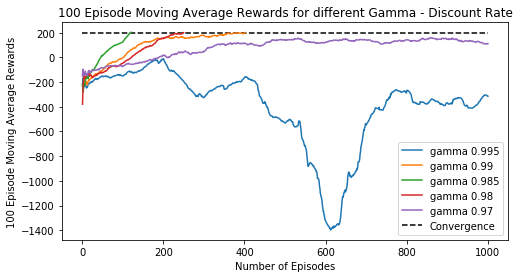

In [41]:
fig= plt.figure(figsize=(8,4))
plt.title('100 Episode Moving Average Rewards for different Gamma - Discount Rate')
plt.plot([i+1 for i in range(0, len(agent2_trial_score))],agent2_trial_score,label='gamma 0.995',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent1_trial_score))],agent1_trial_score,label='gamma 0.99',alpha=1  )
plt.plot([i+1 for i in range(0, len(agent5_trial_score))],agent5_trial_score,label='gamma 0.985',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent3_trial_score))],agent3_trial_score,label='gamma 0.98',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent4_trial_score))],agent4_trial_score,label='gamma 0.97',alpha=1 )
plt.hlines(200, 0, 1000,colors='k',linestyles='--',label='Convergence')
plt.legend(loc='lower right')
plt.xlabel("Number of Episodes")
plt.ylabel("100 Episode Moving Average Rewards")
plt.show()

In [50]:
import pickle
with open('LLGammaTrials.pkl', 'wb') as f:
    pickle.dump(agent1_trial_score, f)
    pickle.dump(agent2_trial_score, f)
    pickle.dump(agent3_trial_score, f)
    pickle.dump(agent4_trial_score, f)
    pickle.dump(agent5_trial_score, f)

In [13]:
with open('LLTrials.pkl', 'rb') as f:
    check1 = pickle.load(f)
    check2 = pickle.load(f)
    check3 = pickle.load(f)
    check4 = pickle.load(f)

## Experiment for learning rate ##

### Learning Rate Experiment 1 - lr=0.005, gamma=0.98, epsilon=1, epsilon_decay=0.996, episodes=1000 ###

In [15]:
agent1_lr_exp = DQN(env, .005, .98, 1, .996, 1000)
agent1_lr_exp_trial_score=agent1_lr_exp.train()

episode: 0/1000, score: -98.23961664985507
Average over last 100 episode: -98.24 

episode: 1/1000, score: -0.45345791349917874
Average over last 100 episode: -49.35 

episode: 2/1000, score: -50.464992555807086
Average over last 100 episode: -49.72 

episode: 3/1000, score: -106.34084409166506
Average over last 100 episode: -63.87 

episode: 4/1000, score: -306.0561350336735
Average over last 100 episode: -112.31 

episode: 5/1000, score: -230.54300108048412
Average over last 100 episode: -132.02 

episode: 6/1000, score: -518.4119360387535
Average over last 100 episode: -187.22 

episode: 7/1000, score: -298.11217329039755
Average over last 100 episode: -201.08 

episode: 8/1000, score: -118.25958778388849
Average over last 100 episode: -191.88 

episode: 9/1000, score: -124.88290684807401
Average over last 100 episode: -185.18 

episode: 10/1000, score: -201.586674104466
Average over last 100 episode: -186.67 

episode: 11/1000, score: -106.61460263856446
Average over last 100 episo

episode: 97/1000, score: 124.41167876022382
Average over last 100 episode: -171.07 

episode: 98/1000, score: -62.0332888449703
Average over last 100 episode: -169.97 

episode: 99/1000, score: 215.55598682083627
Average over last 100 episode: -166.12 

episode: 100/1000, score: 213.81629475522288
Average over last 100 episode: -163.00 

episode: 101/1000, score: 51.7126809017642
Average over last 100 episode: -162.47 

episode: 102/1000, score: 59.019212452721305
Average over last 100 episode: -161.38 

episode: 103/1000, score: 21.352495545011077
Average over last 100 episode: -160.10 

episode: 104/1000, score: -240.56518092106347
Average over last 100 episode: -159.45 

episode: 105/1000, score: 191.23484973370785
Average over last 100 episode: -155.23 

episode: 106/1000, score: -20.138964387959106
Average over last 100 episode: -150.25 

episode: 107/1000, score: 104.73790599861908
Average over last 100 episode: -146.22 

episode: 108/1000, score: 233.48819139606866
Average over 

episode: 194/1000, score: 249.47582982674234
Average over last 100 episode: 111.34 

episode: 195/1000, score: 258.91548400726003
Average over last 100 episode: 117.46 

episode: 196/1000, score: -246.5432836818108
Average over last 100 episode: 114.43 

episode: 197/1000, score: 256.9213946069849
Average over last 100 episode: 115.75 

episode: 198/1000, score: -84.63738130159243
Average over last 100 episode: 115.53 

episode: 199/1000, score: 258.1841043153315
Average over last 100 episode: 115.96 

episode: 200/1000, score: 289.4037021508701
Average over last 100 episode: 116.71 

episode: 201/1000, score: 252.19333339035626
Average over last 100 episode: 118.72 

episode: 202/1000, score: 294.87058597020615
Average over last 100 episode: 121.07 

episode: 203/1000, score: 278.5058780317399
Average over last 100 episode: 123.65 

episode: 204/1000, score: 210.34971923147583
Average over last 100 episode: 128.16 

episode: 205/1000, score: 261.7557451726443
Average over last 100 epi

episode: 291/1000, score: -44.69746711876337
Average over last 100 episode: 135.68 

episode: 292/1000, score: -448.3056079987772
Average over last 100 episode: 131.83 

episode: 293/1000, score: 256.38515011960885
Average over last 100 episode: 136.08 

episode: 294/1000, score: 262.7113035562997
Average over last 100 episode: 136.21 

episode: 295/1000, score: 229.40986111054877
Average over last 100 episode: 135.92 

episode: 296/1000, score: 258.930924903979
Average over last 100 episode: 140.97 

episode: 297/1000, score: 46.98793669827501
Average over last 100 episode: 138.87 

episode: 298/1000, score: 256.7535618170309
Average over last 100 episode: 142.29 

episode: 299/1000, score: -13.500553630795707
Average over last 100 episode: 139.57 

episode: 300/1000, score: -301.0392176029409
Average over last 100 episode: 133.67 

episode: 301/1000, score: 33.69782820560394
Average over last 100 episode: 131.48 

episode: 302/1000, score: -48.08398610060594
Average over last 100 epi

episode: 389/1000, score: -81.60797939653094
Average over last 100 episode: 4.70 

episode: 390/1000, score: -132.3833328294433
Average over last 100 episode: 4.35 

episode: 391/1000, score: -150.85967677319087
Average over last 100 episode: 3.29 

episode: 392/1000, score: -59.591803868181735
Average over last 100 episode: 7.18 

episode: 393/1000, score: 207.26588244775348
Average over last 100 episode: 6.69 

episode: 394/1000, score: 250.9747290127311
Average over last 100 episode: 6.57 

episode: 395/1000, score: 296.826829134828
Average over last 100 episode: 7.25 

episode: 396/1000, score: 228.02320427727037
Average over last 100 episode: 6.94 

episode: 397/1000, score: 274.65962156492833
Average over last 100 episode: 9.21 

episode: 398/1000, score: 264.68329997372973
Average over last 100 episode: 9.29 

episode: 399/1000, score: 238.28767625585343
Average over last 100 episode: 11.81 

episode: 400/1000, score: -166.69553609415024
Average over last 100 episode: 13.15 

ep

episode: 487/1000, score: 168.5544080272229
Average over last 100 episode: 11.99 

episode: 488/1000, score: 40.295471497268124
Average over last 100 episode: 9.69 

episode: 489/1000, score: 137.4959635043029
Average over last 100 episode: 11.88 

episode: 490/1000, score: 164.08042315908713
Average over last 100 episode: 14.84 

episode: 491/1000, score: 278.88149256163587
Average over last 100 episode: 19.14 

episode: 492/1000, score: 263.39953276334927
Average over last 100 episode: 22.37 

episode: 493/1000, score: 244.1369180338576
Average over last 100 episode: 22.74 

episode: 494/1000, score: 180.76042954161397
Average over last 100 episode: 22.04 

episode: 495/1000, score: 241.47834563433432
Average over last 100 episode: 21.48 

episode: 496/1000, score: 234.97507740159662
Average over last 100 episode: 21.55 

episode: 497/1000, score: -67.71125787606016
Average over last 100 episode: 18.13 

episode: 498/1000, score: 192.7412601162371
Average over last 100 episode: 17.41

episode: 586/1000, score: -262.55695965898906
Average over last 100 episode: 83.37 

episode: 587/1000, score: 172.11426488543975
Average over last 100 episode: 83.40 

episode: 588/1000, score: 250.37620452306535
Average over last 100 episode: 85.50 

episode: 589/1000, score: 110.18668174034599
Average over last 100 episode: 85.23 

episode: 590/1000, score: 188.51634068274154
Average over last 100 episode: 85.48 

episode: 591/1000, score: 229.03605462359386
Average over last 100 episode: 84.98 

episode: 592/1000, score: 249.27874537975984
Average over last 100 episode: 84.84 

episode: 593/1000, score: 227.59770975159975
Average over last 100 episode: 84.67 

episode: 594/1000, score: -1.8763587109575184
Average over last 100 episode: 82.84 

episode: 595/1000, score: 122.51670019972426
Average over last 100 episode: 81.65 

episode: 596/1000, score: 303.1096103860632
Average over last 100 episode: 82.34 

episode: 597/1000, score: 228.83655498304057
Average over last 100 episode:

episode: 684/1000, score: 286.2497192540887
Average over last 100 episode: 138.82 

episode: 685/1000, score: 260.6010313768194
Average over last 100 episode: 141.74 

episode: 686/1000, score: 271.4272433835324
Average over last 100 episode: 147.08 

episode: 687/1000, score: 278.854551412048
Average over last 100 episode: 148.15 

episode: 688/1000, score: 263.3771674763947
Average over last 100 episode: 148.28 

episode: 689/1000, score: -169.45336306919648
Average over last 100 episode: 145.48 

episode: 690/1000, score: 273.13070731387404
Average over last 100 episode: 146.33 

episode: 691/1000, score: 227.99939816741255
Average over last 100 episode: 146.32 

episode: 692/1000, score: 282.4793924040662
Average over last 100 episode: 146.65 

episode: 693/1000, score: 274.44083112305856
Average over last 100 episode: 147.12 

episode: 694/1000, score: 240.0617337278301
Average over last 100 episode: 149.54 

episode: 695/1000, score: -250.29486876863518
Average over last 100 epis

episode: 781/1000, score: -124.977590468488
Average over last 100 episode: 112.80 

episode: 782/1000, score: 256.91300670679544
Average over last 100 episode: 112.55 

episode: 783/1000, score: 257.74580135392114
Average over last 100 episode: 117.50 

episode: 784/1000, score: 252.478963745221
Average over last 100 episode: 117.16 

episode: 785/1000, score: 243.26434738589072
Average over last 100 episode: 116.98 

episode: 786/1000, score: 259.4499363600877
Average over last 100 episode: 116.86 

episode: 787/1000, score: 287.1830147230901
Average over last 100 episode: 116.95 

episode: 788/1000, score: -157.35966892907936
Average over last 100 episode: 112.74 

episode: 789/1000, score: 258.0017717340306
Average over last 100 episode: 117.02 

episode: 790/1000, score: 281.9054207663081
Average over last 100 episode: 117.10 

episode: 791/1000, score: 233.7631506368393
Average over last 100 episode: 117.16 

episode: 792/1000, score: -27.384046932546852
Average over last 100 epis

episode: 878/1000, score: 281.8447536781673
Average over last 100 episode: 185.22 

episode: 879/1000, score: -44.06633624083226
Average over last 100 episode: 185.25 

episode: 880/1000, score: 269.0438695536177
Average over last 100 episode: 189.54 

episode: 881/1000, score: 226.6515221882987
Average over last 100 episode: 193.06 

episode: 882/1000, score: 280.51113945310203
Average over last 100 episode: 193.30 

episode: 883/1000, score: 269.9451207530425
Average over last 100 episode: 193.42 

episode: 884/1000, score: 283.21848559314674
Average over last 100 episode: 193.73 

episode: 885/1000, score: 257.76583385837256
Average over last 100 episode: 193.87 

episode: 886/1000, score: 266.5166107853528
Average over last 100 episode: 193.94 

episode: 887/1000, score: 260.05699574421647
Average over last 100 episode: 193.67 

episode: 888/1000, score: 237.4594657801329
Average over last 100 episode: 197.62 

episode: 889/1000, score: 273.6377005176978
Average over last 100 episo

### Learning Rate Experiment 2 - lr=0.0005, gamma=0.98, epsilon=1, epsilon_decay=0.996, episodes=1000 ###

In [30]:
agent2_lr_exp = DQN(env, .0005, .98, 1, .996, 1000)
agent2_lr_exp_trial_score=agent2_lr_exp.train()

episode: 0/1000, score: -237.28316836934746
Average over last 100 episode: -237.28 

episode: 1/1000, score: -158.16324289889425
Average over last 100 episode: -197.72 

episode: 2/1000, score: -216.3500612395895
Average over last 100 episode: -203.93 

episode: 3/1000, score: -192.4250940347988
Average over last 100 episode: -201.06 

episode: 4/1000, score: -98.98303915394364
Average over last 100 episode: -180.64 

episode: 5/1000, score: -157.56206701785578
Average over last 100 episode: -176.79 

episode: 6/1000, score: -356.9498973652138
Average over last 100 episode: -202.53 

episode: 7/1000, score: -283.0715891147738
Average over last 100 episode: -212.60 

episode: 8/1000, score: -331.59497660170484
Average over last 100 episode: -225.82 

episode: 9/1000, score: -422.079897143946
Average over last 100 episode: -245.45 

episode: 10/1000, score: -199.41157838315303
Average over last 100 episode: -241.26 

episode: 11/1000, score: -267.8875682782126
Average over last 100 episo

episode: 97/1000, score: -35.6803562740871
Average over last 100 episode: -108.32 

episode: 98/1000, score: -47.54633901380181
Average over last 100 episode: -107.71 

episode: 99/1000, score: -17.5039119709033
Average over last 100 episode: -106.80 

episode: 100/1000, score: -39.34737299392032
Average over last 100 episode: -104.82 

episode: 101/1000, score: -27.71917871321587
Average over last 100 episode: -103.52 

episode: 102/1000, score: -78.0687708116663
Average over last 100 episode: -102.14 

episode: 103/1000, score: -4.059220540701046
Average over last 100 episode: -100.25 

episode: 104/1000, score: -3.256491752568718
Average over last 100 episode: -99.30 

episode: 105/1000, score: -19.5301371635068
Average over last 100 episode: -97.92 

episode: 106/1000, score: -125.49712008705546
Average over last 100 episode: -95.60 

episode: 107/1000, score: 10.476041167989864
Average over last 100 episode: -92.67 

episode: 108/1000, score: 3.1592209278241743
Average over last 1

episode: 194/1000, score: -91.67242574438484
Average over last 100 episode: -34.00 

episode: 195/1000, score: -15.323770577795223
Average over last 100 episode: -33.38 

episode: 196/1000, score: -4.605871965994688
Average over last 100 episode: -33.16 

episode: 197/1000, score: -52.47794171164086
Average over last 100 episode: -33.32 

episode: 198/1000, score: 11.716713260377176
Average over last 100 episode: -32.73 

episode: 199/1000, score: -32.661782860074695
Average over last 100 episode: -32.88 

episode: 200/1000, score: -63.224198113186986
Average over last 100 episode: -33.12 

episode: 201/1000, score: -29.224578783198858
Average over last 100 episode: -33.14 

episode: 202/1000, score: -227.67985628459894
Average over last 100 episode: -34.63 

episode: 203/1000, score: 14.009958818552775
Average over last 100 episode: -34.45 

episode: 204/1000, score: -2.861470849521229
Average over last 100 episode: -34.45 

episode: 205/1000, score: -93.08501331065511
Average over la

episode: 292/1000, score: 277.151985381906
Average over last 100 episode: 67.12 

episode: 293/1000, score: 225.5971488402609
Average over last 100 episode: 69.68 

episode: 294/1000, score: 230.81525389853238
Average over last 100 episode: 72.91 

episode: 295/1000, score: 243.64944073826547
Average over last 100 episode: 75.50 

episode: 296/1000, score: 249.82500686388525
Average over last 100 episode: 78.04 

episode: 297/1000, score: 234.47087133377573
Average over last 100 episode: 80.91 

episode: 298/1000, score: 247.96216047428703
Average over last 100 episode: 83.28 

episode: 299/1000, score: 225.603283413253
Average over last 100 episode: 85.86 

episode: 300/1000, score: 217.10089332614308
Average over last 100 episode: 88.66 

episode: 301/1000, score: 158.3737055301774
Average over last 100 episode: 90.54 

episode: 302/1000, score: 266.545061363003
Average over last 100 episode: 95.48 

episode: 303/1000, score: -51.1604390725344
Average over last 100 episode: 94.83 

e

### Learning Rate Experiment 3 - lr=0.0025, gamma=0.98, epsilon=1, epsilon_decay=0.996, episodes=1000 ###

In [32]:
agent3_lr_exp = DQN(env, .0025, .98, 1, .996, 1000)
agent3_lr_exp_trial_score=agent3_lr_exp.train()

episode: 0/1000, score: -380.0526963228524
Average over last 100 episode: -380.05 

episode: 1/1000, score: -96.24308325977219
Average over last 100 episode: -238.15 

episode: 2/1000, score: -120.36188688169088
Average over last 100 episode: -198.89 

episode: 3/1000, score: -394.0029867075739
Average over last 100 episode: -247.67 

episode: 4/1000, score: -50.34768402856692
Average over last 100 episode: -208.20 

episode: 5/1000, score: -70.24425902609848
Average over last 100 episode: -185.21 

episode: 6/1000, score: -123.23782588719135
Average over last 100 episode: -176.36 

episode: 7/1000, score: -100.11991966607181
Average over last 100 episode: -166.83 

episode: 8/1000, score: -41.284250336079374
Average over last 100 episode: -152.88 

episode: 9/1000, score: -158.9663788069297
Average over last 100 episode: -153.49 

episode: 10/1000, score: -312.4646171916092
Average over last 100 episode: -167.94 

episode: 11/1000, score: -150.97490278139875
Average over last 100 epis

episode: 96/1000, score: -6.795419989424205
Average over last 100 episode: -137.04 

episode: 97/1000, score: -85.88716486933797
Average over last 100 episode: -136.52 

episode: 98/1000, score: 207.05244926478574
Average over last 100 episode: -133.04 

episode: 99/1000, score: 234.32946802972526
Average over last 100 episode: -129.37 

episode: 100/1000, score: 224.5289694638999
Average over last 100 episode: -123.33 

episode: 101/1000, score: 305.2833183988588
Average over last 100 episode: -119.31 

episode: 102/1000, score: 254.51863208409029
Average over last 100 episode: -115.56 

episode: 103/1000, score: 268.51115194148247
Average over last 100 episode: -108.94 

episode: 104/1000, score: -215.84673031547658
Average over last 100 episode: -110.59 

episode: 105/1000, score: 140.3126718911653
Average over last 100 episode: -108.49 

episode: 106/1000, score: 120.18398559096372
Average over last 100 episode: -106.05 

episode: 107/1000, score: 215.7567439028014
Average over las

episode: 194/1000, score: 297.9630639490248
Average over last 100 episode: 87.25 

episode: 195/1000, score: 265.8588679281643
Average over last 100 episode: 91.48 

episode: 196/1000, score: 255.36991602620142
Average over last 100 episode: 94.10 

episode: 197/1000, score: 27.665728840556056
Average over last 100 episode: 95.24 

episode: 198/1000, score: -82.20302695795827
Average over last 100 episode: 92.35 

episode: 199/1000, score: 135.55067546688713
Average over last 100 episode: 91.36 

episode: 200/1000, score: 240.8652056263931
Average over last 100 episode: 91.52 

episode: 201/1000, score: 246.5073919225225
Average over last 100 episode: 90.93 

episode: 202/1000, score: 264.38332458621085
Average over last 100 episode: 91.03 

episode: 203/1000, score: 267.8772865245039
Average over last 100 episode: 91.03 

episode: 204/1000, score: 277.35172635756726
Average over last 100 episode: 95.96 

episode: 205/1000, score: 266.46668804414725
Average over last 100 episode: 97.22

episode: 292/1000, score: 278.7461047276461
Average over last 100 episode: 151.21 

episode: 293/1000, score: -309.1505753307976
Average over last 100 episode: 146.35 

episode: 294/1000, score: -88.89815404028721
Average over last 100 episode: 142.48 

episode: 295/1000, score: 242.5737500893139
Average over last 100 episode: 142.25 

episode: 296/1000, score: 174.09951369771795
Average over last 100 episode: 141.44 

episode: 297/1000, score: 261.21729242102725
Average over last 100 episode: 143.77 

episode: 298/1000, score: 274.05093336539187
Average over last 100 episode: 147.34 

episode: 299/1000, score: 239.1432680747428
Average over last 100 episode: 148.37 

episode: 300/1000, score: 249.96224206514063
Average over last 100 episode: 148.46 

episode: 301/1000, score: 255.51305137253522
Average over last 100 episode: 148.55 

episode: 302/1000, score: 238.48399042691395
Average over last 100 episode: 148.30 

episode: 303/1000, score: 206.34028322202096
Average over last 100 e

### Learning Rate Experiment 4 - lr=0.0009, gamma=0.98, epsilon=1, epsilon_decay=0.996, episodes=1000 ###

In [34]:
agent4_lr_exp = DQN(env, .0009, .98, 1, .996, 1000)
agent4_lr_exp_trial_score=agent4_lr_exp.train()

episode: 0/1000, score: -139.69935928252124
Average over last 100 episode: -139.70 

episode: 1/1000, score: -224.01193512547042
Average over last 100 episode: -181.86 

episode: 2/1000, score: -337.00136125549284
Average over last 100 episode: -233.57 

episode: 3/1000, score: -588.7223023352205
Average over last 100 episode: -322.36 

episode: 4/1000, score: -304.4231170513805
Average over last 100 episode: -318.77 

episode: 5/1000, score: -47.501650892322004
Average over last 100 episode: -273.56 

episode: 6/1000, score: -90.3911899218025
Average over last 100 episode: -247.39 

episode: 7/1000, score: -123.93924379875857
Average over last 100 episode: -231.96 

episode: 8/1000, score: -81.59478241367725
Average over last 100 episode: -215.25 

episode: 9/1000, score: -178.7994093014138
Average over last 100 episode: -211.61 

episode: 10/1000, score: 4.725562589547792
Average over last 100 episode: -191.94 

episode: 11/1000, score: -144.19491350375606
Average over last 100 episo

episode: 98/1000, score: 235.59057612541216
Average over last 100 episode: -21.49 

episode: 99/1000, score: 261.96006300734734
Average over last 100 episode: -18.66 

episode: 100/1000, score: 276.32437632107656
Average over last 100 episode: -14.50 

episode: 101/1000, score: 192.70015075973322
Average over last 100 episode: -10.33 

episode: 102/1000, score: 241.19140384907138
Average over last 100 episode: -4.55 

episode: 103/1000, score: -71.36829679800282
Average over last 100 episode: 0.62 

episode: 104/1000, score: -76.25934398189985
Average over last 100 episode: 2.91 

episode: 105/1000, score: -126.35391541475626
Average over last 100 episode: 2.12 

episode: 106/1000, score: -215.08184240030053
Average over last 100 episode: 0.87 

episode: 107/1000, score: 243.86717595286555
Average over last 100 episode: 4.55 

episode: 108/1000, score: 241.40666301210302
Average over last 100 episode: 7.78 

episode: 109/1000, score: 244.74510082931226
Average over last 100 episode: 12

episode: 196/1000, score: 258.75685033736204
Average over last 100 episode: 194.47 

episode: 197/1000, score: -197.36211766834893
Average over last 100 episode: 189.85 

episode: 198/1000, score: 242.76012863264683
Average over last 100 episode: 189.92 

episode: 199/1000, score: 214.4096155107606
Average over last 100 episode: 189.44 

episode: 200/1000, score: 268.3950991661377
Average over last 100 episode: 189.36 

episode: 201/1000, score: 261.0866690852928
Average over last 100 episode: 190.05 

episode: 202/1000, score: 273.71971814169683
Average over last 100 episode: 190.37 

episode: 203/1000, score: 214.7543522090904
Average over last 100 episode: 193.24 

episode: 204/1000, score: 269.3040680996432
Average over last 100 episode: 196.69 

episode: 205/1000, score: 272.0002928243955

 Task Completed! 



### Plotting 100 Episode Moving Average Rewards for different Learning Rate ###

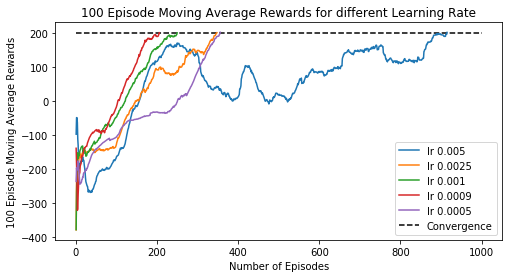

In [42]:
fig= plt.figure(figsize=(8,4))
plt.title('100 Episode Moving Average Rewards for different Learning Rate')
plt.plot([i+1 for i in range(0, len(agent1_lr_exp_trial_score))],agent1_lr_exp_trial_score,label='lr 0.005',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent3_lr_exp_trial_score))],agent3_lr_exp_trial_score,label='lr 0.0025',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent3_trial_score))],agent3_trial_score,label='lr 0.001',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent4_lr_exp_trial_score))],agent4_lr_exp_trial_score,label='lr 0.0009',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent2_lr_exp_trial_score))],agent2_lr_exp_trial_score,label='lr 0.0005',alpha=1 )
plt.hlines(200, 0, 1000,colors='k',linestyles='--',label='Convergence')
plt.legend(loc='lower right')
plt.xlabel("Number of Episodes")
plt.ylabel("100 Episode Moving Average Rewards")
plt.show()

In [51]:
import pickle
with open('LLlrTrials.pkl', 'wb') as f:
    pickle.dump(agent1_lr_exp_trial_score, f)
    pickle.dump(agent3_lr_exp_trial_score, f)
    pickle.dump(agent3_trial_score, f)
    pickle.dump(agent4_lr_exp_trial_score, f)
    pickle.dump(agent2_lr_exp_trial_score, f)

## Experiment for Epsilon decay rate ##

### Epsilon Decay rate Experiment 1 - lr=0.001, gamma=0.98, epsilon=1, epsilon_decay=0.95, episodes=1000 ###

In [43]:
agent1_epsdecay_exp = DQN(env, .001, .98, 1, .95, 1000)
agent1_epsdecay_exp_trial_score=agent1_epsdecay_exp.train()

episode: 0/1000, score: -192.15719102129069
Average over last 100 episode: -192.16 

episode: 1/1000, score: -214.4125117892822
Average over last 100 episode: -203.28 

episode: 2/1000, score: -187.21028832380495
Average over last 100 episode: -197.93 

episode: 3/1000, score: -197.54206029005093
Average over last 100 episode: -197.83 

episode: 4/1000, score: -79.93609385924591
Average over last 100 episode: -174.25 

episode: 5/1000, score: -24.363836087181127
Average over last 100 episode: -149.27 

episode: 6/1000, score: -73.18333933631773
Average over last 100 episode: -138.40 

episode: 7/1000, score: -185.2256268492556
Average over last 100 episode: -144.25 

episode: 8/1000, score: 29.0259337868954
Average over last 100 episode: -125.00 

episode: 9/1000, score: -314.88360320067034
Average over last 100 episode: -143.99 

episode: 10/1000, score: -73.82099832546342
Average over last 100 episode: -137.61 

episode: 11/1000, score: -31.931042938708014
Average over last 100 episo

episode: 98/1000, score: -33.40332677653075
Average over last 100 episode: 53.42 

episode: 99/1000, score: 264.993752704688
Average over last 100 episode: 55.54 

episode: 100/1000, score: 218.01229504371037
Average over last 100 episode: 59.64 

episode: 101/1000, score: 211.9528684893957
Average over last 100 episode: 63.90 

episode: 102/1000, score: 250.28897768284097
Average over last 100 episode: 68.28 

episode: 103/1000, score: 6.3603483401467855
Average over last 100 episode: 70.31 

episode: 104/1000, score: 258.6516341249313
Average over last 100 episode: 73.70 

episode: 105/1000, score: 261.9418405180938
Average over last 100 episode: 76.56 

episode: 106/1000, score: 250.25022392716306
Average over last 100 episode: 79.80 

episode: 107/1000, score: -248.73229770350724
Average over last 100 episode: 79.16 

episode: 108/1000, score: 228.59739421714684
Average over last 100 episode: 81.16 

episode: 109/1000, score: -277.91195281670264
Average over last 100 episode: 81.53

episode: 195/1000, score: 222.44284327537807
Average over last 100 episode: 164.45 

episode: 196/1000, score: 264.4095374733927
Average over last 100 episode: 164.45 

episode: 197/1000, score: 259.4538111249019
Average over last 100 episode: 167.97 

episode: 198/1000, score: 238.5016041498361
Average over last 100 episode: 170.69 

episode: 199/1000, score: 256.7701823656812
Average over last 100 episode: 170.61 

episode: 200/1000, score: 200.80146015970354
Average over last 100 episode: 170.44 

episode: 201/1000, score: 244.21031409653963
Average over last 100 episode: 170.76 

episode: 202/1000, score: 211.44090973349904
Average over last 100 episode: 170.37 

episode: 203/1000, score: 277.9817286676381
Average over last 100 episode: 173.09 

episode: 204/1000, score: 239.3704778723504
Average over last 100 episode: 172.89 

episode: 205/1000, score: 208.549452446867
Average over last 100 episode: 172.36 

episode: 206/1000, score: -149.78679929260676
Average over last 100 episo

### Epsilon Decay rate Experiment 2 - lr=0.001, gamma=0.98, epsilon=1, epsilon_decay=0.9, episodes=1000 ###

In [44]:
agent2_epsdecay_exp = DQN(env, .001, .98, 1, .9, 1000)
agent2_epsdecay_exp_trial_score=agent2_epsdecay_exp.train()

episode: 0/1000, score: -170.2435831932409
Average over last 100 episode: -170.24 

episode: 1/1000, score: -59.478516505826725
Average over last 100 episode: -114.86 

episode: 2/1000, score: -252.34119308788834
Average over last 100 episode: -160.69 

episode: 3/1000, score: -189.8011551971449
Average over last 100 episode: -167.97 

episode: 4/1000, score: -90.84917366198906
Average over last 100 episode: -152.54 

episode: 5/1000, score: -155.17939281349274
Average over last 100 episode: -152.98 

episode: 6/1000, score: -287.5868201251722
Average over last 100 episode: -172.21 

episode: 7/1000, score: -35.87437193175171
Average over last 100 episode: -155.17 

episode: 8/1000, score: -144.87165788295027
Average over last 100 episode: -154.03 

episode: 9/1000, score: -138.90773618865725
Average over last 100 episode: -152.51 

episode: 10/1000, score: -49.31188130102325
Average over last 100 episode: -143.13 

episode: 11/1000, score: 12.106998380895348
Average over last 100 epis

episode: 97/1000, score: 149.6122963808781
Average over last 100 episode: -41.39 

episode: 98/1000, score: -429.9297669489778
Average over last 100 episode: -45.31 

episode: 99/1000, score: -323.6590269899198
Average over last 100 episode: -48.10 

episode: 100/1000, score: 180.79158692349023
Average over last 100 episode: -44.59 

episode: 101/1000, score: 250.47279691838824
Average over last 100 episode: -41.49 

episode: 102/1000, score: 237.77888072832116
Average over last 100 episode: -36.59 

episode: 103/1000, score: 223.87942186461828
Average over last 100 episode: -32.45 

episode: 104/1000, score: 218.87140293614897
Average over last 100 episode: -29.35 

episode: 105/1000, score: -499.4607861503253
Average over last 100 episode: -32.79 

episode: 106/1000, score: -133.4882239460733
Average over last 100 episode: -31.25 

episode: 107/1000, score: -36.169762082041515
Average over last 100 episode: -31.26 

episode: 108/1000, score: 248.78968568802895
Average over last 100 e

episode: 195/1000, score: 287.7650531548529
Average over last 100 episode: 175.27 

episode: 196/1000, score: 248.96310725969212
Average over last 100 episode: 175.35 

episode: 197/1000, score: 206.17773106265355
Average over last 100 episode: 175.92 

episode: 198/1000, score: 235.77692896515
Average over last 100 episode: 182.57 

episode: 199/1000, score: 260.2508277461635
Average over last 100 episode: 188.41 

episode: 200/1000, score: 267.3843386079195
Average over last 100 episode: 189.28 

episode: 201/1000, score: 248.48784642329616
Average over last 100 episode: 189.26 

episode: 202/1000, score: 242.92125769674067
Average over last 100 episode: 189.31 

episode: 203/1000, score: 13.196791901428682
Average over last 100 episode: 187.20 

episode: 204/1000, score: 237.4942019359012
Average over last 100 episode: 187.39 

episode: 205/1000, score: 274.7791384937991
Average over last 100 episode: 195.13 

episode: 206/1000, score: 239.38702565659432
Average over last 100 episod

### Epsilon Decay rate Experiment 3 - lr=0.001, gamma=0.98, epsilon=1, epsilon_decay=0.8, episodes=1000 ###

In [45]:
agent3_epsdecay_exp = DQN(env, .001, .98, 1, .8, 1000)
agent3_epsdecay_exp_trial_score=agent3_epsdecay_exp.train()

episode: 0/1000, score: -197.0598522462278
Average over last 100 episode: -197.06 

episode: 1/1000, score: -161.5309141695349
Average over last 100 episode: -179.30 

episode: 2/1000, score: -115.10099258778398
Average over last 100 episode: -157.90 

episode: 3/1000, score: -268.93122991856944
Average over last 100 episode: -185.66 

episode: 4/1000, score: -348.7565354324345
Average over last 100 episode: -218.28 

episode: 5/1000, score: -142.5243484864226
Average over last 100 episode: -205.65 

episode: 6/1000, score: -163.01479499998476
Average over last 100 episode: -199.56 

episode: 7/1000, score: -305.55270419126236
Average over last 100 episode: -212.81 

episode: 8/1000, score: -115.60445457793027
Average over last 100 episode: -202.01 

episode: 9/1000, score: -147.1609482079012
Average over last 100 episode: -196.52 

episode: 10/1000, score: -53.013399024883135
Average over last 100 episode: -183.48 

episode: 11/1000, score: -78.45063737543744
Average over last 100 epi

episode: 97/1000, score: 62.40036193798381
Average over last 100 episode: -43.20 

episode: 98/1000, score: 84.06149058807013
Average over last 100 episode: -41.91 

episode: 99/1000, score: 138.30808834197447
Average over last 100 episode: -40.11 

episode: 100/1000, score: 48.50785914452177
Average over last 100 episode: -37.66 

episode: 101/1000, score: 214.803333767128
Average over last 100 episode: -33.89 

episode: 102/1000, score: 223.79155394014347
Average over last 100 episode: -30.50 

episode: 103/1000, score: 142.8054834301842
Average over last 100 episode: -26.39 

episode: 104/1000, score: 99.81820039430303
Average over last 100 episode: -21.90 

episode: 105/1000, score: -108.85450421453714
Average over last 100 episode: -21.56 

episode: 106/1000, score: 171.03454039411605
Average over last 100 episode: -18.22 

episode: 107/1000, score: -106.92682090143116
Average over last 100 episode: -16.24 

episode: 108/1000, score: 257.61641648862815
Average over last 100 episod

episode: 195/1000, score: 220.57579293442808
Average over last 100 episode: 127.46 

episode: 196/1000, score: 259.2824870880778
Average over last 100 episode: 129.34 

episode: 197/1000, score: 267.2648306685901
Average over last 100 episode: 131.39 

episode: 198/1000, score: 272.6588230102475
Average over last 100 episode: 133.27 

episode: 199/1000, score: -227.45371682398206
Average over last 100 episode: 129.62 

episode: 200/1000, score: 212.63349984325453
Average over last 100 episode: 131.26 

episode: 201/1000, score: 266.7482017473127
Average over last 100 episode: 131.78 

episode: 202/1000, score: -14.095988274095959
Average over last 100 episode: 129.40 

episode: 203/1000, score: -31.1297145936326
Average over last 100 episode: 127.66 

episode: 204/1000, score: -53.78066923558212
Average over last 100 episode: 126.12 

episode: 205/1000, score: 224.12659310736348
Average over last 100 episode: 129.45 

episode: 206/1000, score: 244.00704713568638
Average over last 100 e

episode: 292/1000, score: 283.47671889762745
Average over last 100 episode: 172.17 

episode: 293/1000, score: 252.06558160669408
Average over last 100 episode: 172.06 

episode: 294/1000, score: -95.55726656041577
Average over last 100 episode: 171.73 

episode: 295/1000, score: 182.38023512791565
Average over last 100 episode: 171.35 

episode: 296/1000, score: 208.7616384472247
Average over last 100 episode: 170.85 

episode: 297/1000, score: 212.5587587142959
Average over last 100 episode: 170.30 

episode: 298/1000, score: 229.93369556267467
Average over last 100 episode: 169.87 

episode: 299/1000, score: 283.59564118763467
Average over last 100 episode: 174.98 

episode: 300/1000, score: 250.956300555305
Average over last 100 episode: 175.37 

episode: 301/1000, score: 209.31725107142756
Average over last 100 episode: 174.79 

episode: 302/1000, score: 187.99081061909845
Average over last 100 episode: 176.81 

episode: 303/1000, score: 217.7754845652833
Average over last 100 epi

### Epsilon Decay rate Experiment 4 - lr=0.001, gamma=0.98, epsilon=1, epsilon_decay=0.6, episodes=1000 ###

In [46]:
agent4_epsdecay_exp = DQN(env, .001, .98, 1, .6, 1000)
agent4_epsdecay_exp_trial_score=agent4_epsdecay_exp.train()

episode: 0/1000, score: -46.34966860911368
Average over last 100 episode: -46.35 

episode: 1/1000, score: -297.543394425423
Average over last 100 episode: -171.95 

episode: 2/1000, score: -263.3649930471679
Average over last 100 episode: -202.42 

episode: 3/1000, score: -240.4337396133606
Average over last 100 episode: -211.92 

episode: 4/1000, score: -157.11094781457257
Average over last 100 episode: -200.96 

episode: 5/1000, score: -287.86092825980177
Average over last 100 episode: -215.44 

episode: 6/1000, score: -253.37228718678008
Average over last 100 episode: -220.86 

episode: 7/1000, score: -253.72927709855875
Average over last 100 episode: -224.97 

episode: 8/1000, score: -238.4104925701162
Average over last 100 episode: -226.46 

episode: 9/1000, score: -198.9531255969747
Average over last 100 episode: -223.71 

episode: 10/1000, score: -152.54997616875377
Average over last 100 episode: -217.24 

episode: 11/1000, score: -215.38684208816704
Average over last 100 episo

episode: 97/1000, score: -173.34654450214373
Average over last 100 episode: -79.94 

episode: 98/1000, score: -234.22823072457194
Average over last 100 episode: -81.50 

episode: 99/1000, score: -150.84004868369118
Average over last 100 episode: -82.20 

episode: 100/1000, score: -128.3191497383675
Average over last 100 episode: -83.02 

episode: 101/1000, score: -183.3835657300115
Average over last 100 episode: -81.87 

episode: 102/1000, score: -31.67035076849328
Average over last 100 episode: -79.56 

episode: 103/1000, score: -103.59044254909678
Average over last 100 episode: -78.19 

episode: 104/1000, score: 242.8459480333995
Average over last 100 episode: -74.19 

episode: 105/1000, score: 166.92226637456469
Average over last 100 episode: -69.64 

episode: 106/1000, score: -96.55086204608983
Average over last 100 episode: -68.07 

episode: 107/1000, score: 227.47563749712208
Average over last 100 episode: -63.26 

episode: 108/1000, score: 214.6962669666193
Average over last 100

episode: 195/1000, score: 67.94869268310705
Average over last 100 episode: 104.44 

episode: 196/1000, score: -24.442486815614558
Average over last 100 episode: 105.73 

episode: 197/1000, score: 193.9021148097856
Average over last 100 episode: 109.40 

episode: 198/1000, score: 265.5462845671466
Average over last 100 episode: 114.40 

episode: 199/1000, score: 187.533016888177
Average over last 100 episode: 117.78 

episode: 200/1000, score: 216.02949387119833
Average over last 100 episode: 121.23 

episode: 201/1000, score: 22.307530051950437
Average over last 100 episode: 123.28 

episode: 202/1000, score: 236.57143146625802
Average over last 100 episode: 125.97 

episode: 203/1000, score: 30.92392351916098
Average over last 100 episode: 127.31 

episode: 204/1000, score: 157.05528880672767
Average over last 100 episode: 126.45 

episode: 205/1000, score: 1.9446075797145
Average over last 100 episode: 124.80 

episode: 206/1000, score: 274.78469816369795
Average over last 100 episod

episode: 292/1000, score: 280.11217171773853
Average over last 100 episode: 147.55 

episode: 293/1000, score: 285.93669187623505
Average over last 100 episode: 151.19 

episode: 294/1000, score: 258.87347920748743
Average over last 100 episode: 153.72 

episode: 295/1000, score: 272.70036755484534
Average over last 100 episode: 155.77 

episode: 296/1000, score: 274.3935250514434
Average over last 100 episode: 158.76 

episode: 297/1000, score: 231.05956932492813
Average over last 100 episode: 159.13 

episode: 298/1000, score: 231.23131261667737
Average over last 100 episode: 158.79 

episode: 299/1000, score: 234.6558317453801
Average over last 100 episode: 159.26 

episode: 300/1000, score: 215.39245968732723
Average over last 100 episode: 159.25 

episode: 301/1000, score: 241.85539784098953
Average over last 100 episode: 161.45 

episode: 302/1000, score: 274.7439853464882
Average over last 100 episode: 161.83 

episode: 303/1000, score: -85.44043985226367
Average over last 100 e

episode: 389/1000, score: 241.66637854046414
Average over last 100 episode: 183.64 

episode: 390/1000, score: 231.03669745029146
Average over last 100 episode: 183.24 

episode: 391/1000, score: 262.23348059949313
Average over last 100 episode: 183.40 

episode: 392/1000, score: 280.1700746213776
Average over last 100 episode: 183.40 

episode: 393/1000, score: 280.1138816962873
Average over last 100 episode: 183.34 

episode: 394/1000, score: 239.83005350609335
Average over last 100 episode: 183.15 

episode: 395/1000, score: 241.12117700055444
Average over last 100 episode: 182.83 

episode: 396/1000, score: 277.7084765500913
Average over last 100 episode: 182.87 

episode: 397/1000, score: -243.84491566581588
Average over last 100 episode: 178.12 

episode: 398/1000, score: 272.3832405763733
Average over last 100 episode: 178.53 

episode: 399/1000, score: 233.86582106081116
Average over last 100 episode: 178.52 

episode: 400/1000, score: -282.9106159203294
Average over last 100 e

### Epsilon Decay rate Experiment 5 - lr=0.001, gamma=0.98, epsilon=1, epsilon_decay=0.5, episodes=1000 ###

In [53]:
agent5_epsdecay_exp = DQN(env, .001, .98, 1, .5, 1000)
agent5_epsdecay_exp_trial_score=agent5_epsdecay_exp.train()

episode: 0/1000, score: -146.2184080890931
Average over last 100 episode: -146.22 

episode: 1/1000, score: -125.19067210404954
Average over last 100 episode: -135.70 

episode: 2/1000, score: -129.28553644594749
Average over last 100 episode: -133.56 

episode: 3/1000, score: -234.16981441707156
Average over last 100 episode: -158.72 

episode: 4/1000, score: -237.93985838192233
Average over last 100 episode: -174.56 

episode: 5/1000, score: -105.60987965382026
Average over last 100 episode: -163.07 

episode: 6/1000, score: -392.5531930725703
Average over last 100 episode: -195.85 

episode: 7/1000, score: -283.0696523337176
Average over last 100 episode: -206.75 

episode: 8/1000, score: -162.14396264164895
Average over last 100 episode: -201.80 

episode: 9/1000, score: 62.147935311932216
Average over last 100 episode: -175.40 

episode: 10/1000, score: -87.94580657539895
Average over last 100 episode: -167.45 

episode: 11/1000, score: -83.10450799681108
Average over last 100 epi

episode: 98/1000, score: 241.40580907481473
Average over last 100 episode: 34.23 

episode: 99/1000, score: 233.50863367374083
Average over last 100 episode: 36.22 

episode: 100/1000, score: 278.5606619453857
Average over last 100 episode: 40.47 

episode: 101/1000, score: -26.726711282275645
Average over last 100 episode: 41.45 

episode: 102/1000, score: 190.0366494473769
Average over last 100 episode: 44.65 

episode: 103/1000, score: -6.594406325892237
Average over last 100 episode: 46.92 

episode: 104/1000, score: 19.717638854835172
Average over last 100 episode: 49.50 

episode: 105/1000, score: 197.56896276689804
Average over last 100 episode: 52.53 

episode: 106/1000, score: 260.314451459608
Average over last 100 episode: 59.06 

episode: 107/1000, score: -15.56081074908191
Average over last 100 episode: 61.74 

episode: 108/1000, score: -203.54962716164817
Average over last 100 episode: 61.32 

episode: 109/1000, score: 269.6825640842359
Average over last 100 episode: 63.40

episode: 196/1000, score: 279.5007864920099
Average over last 100 episode: 142.53 

episode: 197/1000, score: 238.4652877133745
Average over last 100 episode: 142.58 

episode: 198/1000, score: 241.72124868697523
Average over last 100 episode: 142.58 

episode: 199/1000, score: 259.36102459623254
Average over last 100 episode: 142.84 

episode: 200/1000, score: 277.51242532579084
Average over last 100 episode: 142.83 

episode: 201/1000, score: 258.7412693103863
Average over last 100 episode: 145.68 

episode: 202/1000, score: 252.41657879107728
Average over last 100 episode: 146.31 

episode: 203/1000, score: 251.3180843830731
Average over last 100 episode: 148.89 

episode: 204/1000, score: -62.115459223501006
Average over last 100 episode: 148.07 

episode: 205/1000, score: -104.15094425179599
Average over last 100 episode: 145.05 

episode: 206/1000, score: 207.25967325737457
Average over last 100 episode: 144.52 

episode: 207/1000, score: 279.98494976404305
Average over last 100 

### Plotting 100 Episode Moving Average Rewards for different Epsilon decay rate ###

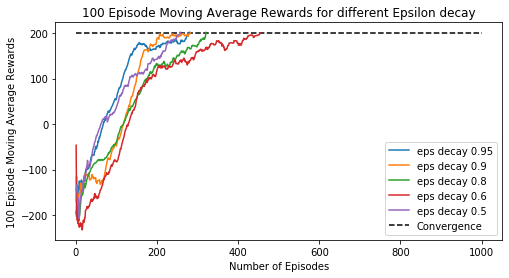

In [55]:
fig= plt.figure(figsize=(8,4))
plt.title('100 Episode Moving Average Rewards for different Epsilon decay')
plt.plot([i+1 for i in range(0, len(agent1_epsdecay_exp_trial_score))],agent1_epsdecay_exp_trial_score,label='eps decay 0.95',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent2_epsdecay_exp_trial_score))],agent2_epsdecay_exp_trial_score,label='eps decay 0.9',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent3_epsdecay_exp_trial_score))],agent3_epsdecay_exp_trial_score,label='eps decay 0.8',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent4_epsdecay_exp_trial_score))],agent4_epsdecay_exp_trial_score,label='eps decay 0.6',alpha=1 )
plt.plot([i+1 for i in range(0, len(agent5_epsdecay_exp_trial_score))],agent5_epsdecay_exp_trial_score,label='eps decay 0.5',alpha=1 )
plt.hlines(200, 0, 1000,colors='k',linestyles='--',label='Convergence')
plt.legend(loc='lower right')
plt.xlabel("Number of Episodes")
plt.ylabel("100 Episode Moving Average Rewards")
plt.show()